# **Image Caption Generator Using Transformer Model**

Installing Required Libraries

In [1]:
!pip install gdown
!pip install -q 'tensorflow-text==2.11.*'
!pip install -q tensorflow_datasets
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 require

**Importing Necessary Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams
import gdown
import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

**Downloading Dataset from Google Drive Using gdown**

In [3]:
# Replace with your file ID
file_id = '1Xqwvqi3mxfgJESBqiJXE9MaABByF0cpG'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'your_dataset.zip'  # Name the output file

gdown.download(url, output, quiet=False)
!unzip your_dataset.zip


Downloading...
From (original): https://drive.google.com/uc?id=1Xqwvqi3mxfgJESBqiJXE9MaABByF0cpG
From (redirected): https://drive.google.com/uc?id=1Xqwvqi3mxfgJESBqiJXE9MaABByF0cpG&confirm=t&uuid=88ea1528-f348-46a5-817d-bb456245991f
To: /content/your_dataset.zip
100%|██████████| 1.12G/1.12G [00:22<00:00, 49.3MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: Image caption generator Dataset/Images/2844846111_8c1cbfc75d.jpg  
  inflating: __MACOSX/Image caption generator Dataset/Images/._2844846111_8c1cbfc75d.jpg  
  inflating: Image caption generator Dataset/Images/1082252566_8c79beef93.jpg  
  inflating: __MACOSX/Image caption generator Dataset/Images/._1082252566_8c79beef93.jpg  
  inflating: Image caption generator Dataset/Images/1386251841_5f384a0fea.jpg  
  inflating: __MACOSX/Image caption generator Dataset/Images/._1386251841_5f384a0fea.jpg  
  inflating: Image caption generator Dataset/Images/2196316998_3b2d63f01f.jpg  
  inflating: __MACOSX/Image caption generator Dataset/Images/._2196316998_3b2d63f01f.jpg  
  inflating: Image caption generator Dataset/Images/3106791484_13e18c33d8.jpg  
  inflating: __MACOSX/Image caption generator Dataset/Images/._3106791484_13e18c33d8.jpg  
  inflating: Image caption generator Dataset/Images/3603064161_a8f3b6455d.jpg  
  inflating: _

Setting Environment Variables and Downloading NLTK Data

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Generating Image Caption Dataset**

In [5]:
def get_dataset(path='/content/Image caption generator Dataset'):
    path = pathlib.Path(path)
    captions_path = path / 'captions.txt'
    images_folder = path / 'Images'

    # Read captions
    captions_lines = captions_path.read_text().strip().split('\n')
    captions = [line.split(',', 1) for line in captions_lines if ',' in line]  # Split line into image path and caption

    # Create a dictionary to store captions grouped by image path
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    # List of all images
    all_images = list(images_folder.glob('*.jpg'))
    print(f"Total images: {len(all_images)}")

    # Split into train and test (80-20 split)
    train_size = int(0.9 * len(all_images))
    train_imgs_path = all_images[:train_size]
    test_imgs_path = all_images[train_size:]

    def train_generator():
        # Iterate over training image paths and yield each path with its corresponding caption
        for img_path in train_imgs_path:
            yield str(img_path), tf.constant(cap_dict[img_path.name], dtype=tf.string)

    def test_generator():
        # Iterate over test image paths and yield each path with its corresponding caption
        for img_path in test_imgs_path:
            yield str(img_path), tf.constant(cap_dict[img_path.name], dtype=tf.string)

    # Create a TensorFlow Dataset from the generator function for training data
    train_dataset = tf.data.Dataset.from_generator(
        train_generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # Output type for image path
            tf.TensorSpec(shape=(None,), dtype=tf.string)  # Output type for caption (variable length)
        )
    )

    # Create a TensorFlow Dataset from the generator function for test data
    test_dataset = tf.data.Dataset.from_generator(
        test_generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # Output type for image path
            tf.TensorSpec(shape=(None,), dtype=tf.string)  # Output type for caption (variable length)
        )
    )

    # Calculate and print the sizes of the datasets
    train_data_size = sum(1 for _ in train_dataset)
    test_data_size = sum(1 for _ in test_dataset)
    print(f"Training data size: {train_data_size}")
    print(f"Testing data size: {test_data_size}")

    return train_dataset, test_dataset

**Loading and Processing Image Caption Dataset**

In [6]:
# Load and process the dataset
train_data, test_data = get_dataset()

print()
# Check the first few examples in the training dataset
for img_path, captions in train_data.take(1):
    print(f"Image path for sample train data: {img_path.numpy().decode('utf-8')}")
    for caption in captions.numpy():
        print(f"Caption: {caption.decode('utf-8')}")

print()
# Check the first few examples in the test dataset
for img_path, captions in test_data.take(1):
    print(f"Image path for sample test data: {img_path.numpy().decode('utf-8')}")
    for caption in captions.numpy():
        print(f"Caption: {caption.decode('utf-8')}")

Total images: 8091
Training data size: 7281
Testing data size: 810

Image path for sample train data: /content/Image caption generator Dataset/Images/254527963_3f5824b0e8.jpg
Caption: A black dog is running along the beach .
Caption: A black dog running on a beach .
Caption: A black dog running on the beach
Caption: A dog walking away at the beach .
Caption: "A large , black dog is running in the sand on the beach ."

Image path for sample test data: /content/Image caption generator Dataset/Images/3725353555_75c346d7ec.jpg
Caption: A brown and black dog is jumping through a sprinkler .
Caption: A dog playing with a sprinkler
Caption: A German Shepherd runs through a sprinkler .
Caption: A tan and black dog jumps through a water sprinkler in the yard .
Caption: The German shepherd dog is jumping up as it is being squirted with a jet of water .


# **Feature Extraction with MobileNetV3 Small**

In [7]:
# Define the input shape for the feature extractor
image_shape = (224, 224, 3)

# Instantiate MobileNetV3Small as a feature extractor for images
feature_extractor = tf.keras.applications.MobileNetV3Small(
    input_shape=image_shape,            # Specify input image shape
    include_preprocessing=True,         # Include preprocessing layers for MobileNetV3
    include_top=False                   # Exclude the fully-connected layers at the top
)

# Set the feature extractor's layers as non-trainable
feature_extractor.trainable = False


4334752/4334752 [==============================] - 0s 0us/step


Function to Load and Preprocess Image

In [8]:
def load_img(img_path):
    # Read image file from the provided path
    img = tf.io.read_file(img_path)

    # Decode the JPEG-encoded image into a tensor with 3 channels (RGB)
    img = tf.io.decode_jpeg(img, channels=3)

    # Resize the image to match the specified image_shape, excluding the channel dimension
    img = tf.image.resize(img, image_shape[:-1])

    return img


Loading and Extracting Features from an Image

In [9]:
img = load_img(img_path.numpy().decode('utf-8'))

# Print the shape of the loaded and processed image tensor
print(img.shape)

# Extract image features using the feature_extractor model and print the shape
print(feature_extractor(img[tf.newaxis, ...]).shape)


(224, 224, 3)
(1, 7, 7, 576)


Function for Text Standardization

In [10]:
def standardize(text):
    # Convert text to lowercase
    text = tf.strings.lower(text)

    # Remove punctuation using regex
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')

    # Add start and end tokens to the text
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

    return text

    #Example
    standardize('A black dog is running after a white dog in the snow .')

**Text Vectorization with TextVectorization and StringLookup**

In [11]:
vocab_size = 5000

# Text vectorization layer using standardize function
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=standardize,
    ragged=True  # Allows handling of variable-length text sequences
)

# Adapt the vectorizer to the training data
vectorizer.adapt(train_data.map(lambda img_path, cap: cap).unbatch().batch(1024))

# Print the first 10 vocabulary tokens
print(vectorizer.get_vocabulary()[:10])

# String lookup layer to convert text to IDs
text_to_id_vectorizer = tf.keras.layers.StringLookup(
    vocabulary=vectorizer.get_vocabulary(),
    mask_token='',  # Token to mask out during training
)

# String lookup layer to convert IDs back to text
id_to_text_vectorizer = tf.keras.layers.StringLookup(
    vocabulary=vectorizer.get_vocabulary(),
    mask_token='',  # Token to mask out during training
    invert=True  # Inverts the lookup (ID to text)
)


['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']


**Text Processing**

In [12]:
def id_to_text(token_ids, reserved_tokens=['', '[UNK]', '[START]', '[END]']):
    """
    Converts token IDs back to text, filtering out reserved tokens and joining words into a coherent sentence.

    Args:
    - token_ids (tf.Tensor): Tensor containing token IDs to convert to text.
    - reserved_tokens (list): List of reserved tokens to filter out from the text conversion.

    Returns:
    - tf.Tensor: Tensor of strings representing the converted text.
    """
    # Convert token IDs to words using id_to_text_vectorizer
    words = id_to_text_vectorizer(token_ids)

    # Create a regular expression to match reserved tokens (except [UNK])
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)

    # Create a boolean mask to filter out bad tokens
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)

    # Apply the mask to filter out bad tokens from words
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    # Reduce join the words into a coherent sentence
    sentence = tf.strings.reduce_join(words, axis=-1, separator=' ')

    return sentence


**Data Serialization**

In [13]:
def serialize_data(images, captions):
    """
    Serializes image and caption data into compatible formats for model training.

    Args:
    - images (tf.Tensor): Tensor containing image data.
    - captions (tf.Tensor): Tensor containing caption data.

    Returns:
    - tuple: A tuple containing serialized images and captions.
    """
    # Parse the shape of the captions tensor
    captions_shape = einops.parse_shape(captions, 'b c')

    # Rearrange captions tensor to match the serialization format
    captions = einops.rearrange(captions, 'b c -> (b c)')

    # Repeat images tensor to match the serialization format
    images = einops.repeat(images, 'b ... -> (b c) ...', c=captions_shape['c'])

    return images, captions


Processing Batch of Image and Caption Data


In [14]:
# Load a batch of images and captions from the training dataset
for img, cap in train_data.batch(1024).take(5):
    break

# Print the shape of the loaded images and captions tensors
print("Shape of loaded images:", img.shape)
print("Shape of loaded captions:", cap.shape)

# Serialize the loaded images and captions using the serialize_data function
img_serialize, cap_serialize = serialize_data(img, cap)

# Print the shape of the serialized images and captions tensors
print("Serialized images shape:", img_serialize.shape)
print("Serialized captions shape:", cap_serialize.shape)


Shape of loaded images: (1024,)
Shape of loaded captions: (1024, 5)
Serialized images shape: (5120,)
Serialized captions shape: (5120,)


Function to Prepare Batch of Image and Caption Data

In [15]:
def prepare_batch(img, cap):
    """
    Prepare a batch of data for training.

    Args:
    - img: Tensor representing batch of images.
    - cap: Tensor representing batch of captions.

    Returns:
    - Tuple of input and output sequences for captioning model training.
    """
    # Tokenize the captions using the vectorizer layer
    cap_tokenized = vectorizer(cap)

    # Prepare input and output sequences for the model
    cap_tokenized_in = cap_tokenized[:, :-1]         # Input sequence: remove last token (to predict)
    cap_tokenized_out = cap_tokenized[:, 1:]         # Output sequence: remove first token (start token)

    # Convert tokenized sequences to dense tensors
    input_data = (img, cap_tokenized_in.to_tensor())  # Combine image and input caption
    output_data = cap_tokenized_out.to_tensor()       # Output caption sequence

    return input_data, output_data


Function to Save Processed Dataset

In [16]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards=20, batch_size=64):
    """
    Save preprocessed and batched dataset to a sharded TFRecord file.

    Args:
    - raw_ds: Raw dataset containing image paths and captions.
    - file_path: Path to save the TFRecord file.
    - image_feature_extractor: Feature extractor model for images.
    - vectorizer: Text vectorizer for tokenizing captions.
    - shards: Number of shards to split the dataset.
    - batch_size: Batch size for processing data.
    """
    # Preprocess raw dataset: load images and batch captions
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    # Generator function to extract image features and serialize data
    def gen():
        for (img, cap) in tqdm(raw_ds):  # tqdm for progress bar
            img_features = image_feature_extractor(img)  # Extract features from images
            img_features, cap = serialize_data(img_features, cap)  # Serialize image features and captions
            yield img_features, cap

    # Create dataset from generator
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=image_feature_extractor.output_shape),
            tf.TensorSpec(shape=(None,), dtype=tf.string)
        ))

    # Prepare batches for training
    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)  # Prepare batches using prepare_batch function
          .unbatch()  # Unbatch the dataset
          .shuffle(1000))  # Shuffle the dataset

    # Shard function for saving to TFRecord files
    def shard_func(i, data):
        return i % shards

    # Save dataset to TFRecord files
    ds.enumerate().save(file_path, shard_func=shard_func)


In [17]:
%%time
# Save the training dataset to 'train_cache' with timing information
save_dataset(train_data, 'train_cache', feature_extractor, vectorizer)

# Save the test dataset to 'test_cache' with timing information
save_dataset(test_data, 'test_cache', feature_extractor, vectorizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 3min 15s, sys: 1min 19s, total: 4min 35s
Wall time: 6min 3s


Function to Load Dataset

In [18]:
def load_dataset(file_path, batch_size=64, cycle_length=2):
    """
    Load a dataset from TFRecord files, preprocess it, and return a batched and shuffled dataset.

    Args:
    - file_path: Path to the TFRecord file(s) containing serialized data.
    - batch_size: Batch size for training.
    - cycle_length: Number of datasets to load and interleave concurrently.

    Returns:
    - ds: Preprocessed and batched TensorFlow dataset ready for model training.
    """

    # Function to read and preprocess TFRecordDataset
    def reader_func(ds):
        ds = ds.shuffle(1000)  # Shuffle dataset within each shard
        return ds.interleave(lambda x: x, cycle_length=cycle_length)  # Interleave datasets

    # Function to drop the index added by enumerate during saving
    def drop_index(i, x):
        return x

    # Load TFRecordDataset from file_path using reader_func for preprocessing
    ds = tf.data.experimental.load(file_path, reader_func=reader_func)

    # Data pipeline: map drop_index, shuffle, batch, and prefetch for performance
    ds = (ds
          .map(drop_index)  # Drop the index added during saving
          .shuffle(1000)  # Shuffle the dataset for better training
          .padded_batch(batch_size)  # Batch the dataset, padding sequences to the maximum length in the batch
          .prefetch(tf.data.AUTOTUNE))  # Prefetch batches for faster data loading

    return ds


In [19]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)


Previewing Batched Image and Caption Data

In [20]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(64, 7, 7, 576)
(64, 32)
(64, 32)
tf.Tensor(
[  3   2  12   5   2  16 994  51   2  52 222   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(32,), dtype=int64)
tf.Tensor(
[  2  12   5   2  16 994  51   2  52 222   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(32,), dtype=int64)


In [21]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

# **Positional Encoding**

*   Calculates a set of values based on the position of each word in a sentence, helping the model understand the order of words.


In [22]:
def positional_encoding(length, depth):
    """
    Generate positional encoding for a given sequence length and embedding depth.

    Args:
    - length: Integer, length of the sequence.
    - depth: Integer, dimensionality of the embedding vector (should be even).

    Returns:
    - out: Tensor of shape (1, length, depth), positional encoding matrix.

    Positional encoding adds information about the positions of tokens in the sequence.
    It uses sine and cosine functions of different frequencies to represent position information.

    Note: This implementation assumes `depth` is even.
    """

    # Compute positional encodings
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)  # (length, 1)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)   # (1, depth)
    dep = ((dep // 2)*2) / tf.cast(depth, tf.float32)           # Scale depth indices

    angle_rates = 1 / (10000 ** dep)  # Compute angle rates
    angle_rads = pos * angle_rates    # Compute angle radians

    # Apply sine to even indices in the array; 2i
    out = tf.Variable(tf.zeros((length, depth)))  # Initialize output tensor
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))  # Apply sine to even indices

    # Apply cosine to odd indices in the array; 2i+1
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))  # Apply cosine to odd indices

    return out[tf.newaxis, ...]  # Add batch dimension and return positional encoding matrix


In [23]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

Visualizing Positional Encoding Matrix

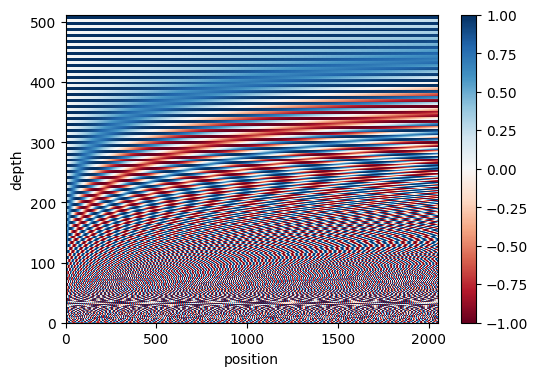

In [24]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

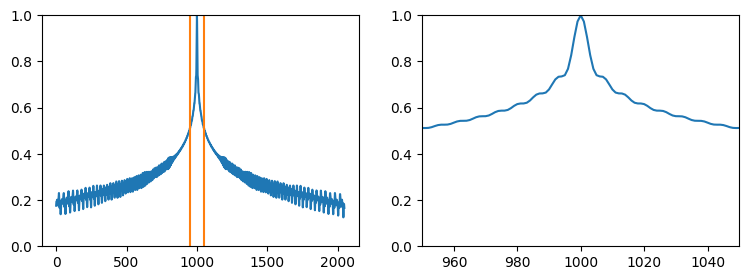

In [25]:
# Compute the L2 normalized vector for a specific position in sample_enc
p_norm = tf.linalg.l2_normalize(sample_enc[1000][tf.newaxis, :])

# Compute L2 normalization across the entire sample_enc along axis 1
sample_enc_norm = tf.linalg.l2_normalize(sample_enc, axis=1)

# Calculate dot products between each normalized vector in sample_enc_norm and p_norm,
# transposing p_norm for proper matrix multiplication
dots = tf.linalg.matmul(sample_enc_norm, p_norm, transpose_b=True)

# Plotting the results
plt.figure(figsize=(9, 3))

# Subplot 1: Plot dots against indices, highlighting positions around index 1000
plt.subplot(1, 2, 1)
plt.plot(dots)
plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1])  # Highlight range around index 1000

# Subplot 2: Plot dots against indices, zoomed into indices 950 to 1050
plt.subplot(1, 2, 2)
plt.plot(dots)
plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
plt.xlim([950, 1050])  # Set x-axis limits to [950, 1050]

plt.show()  # Display the plot


# **Positional Embedding**

*   Combines these positional values with word embeddings to give each word in a sentence a unique representation that includes its position, aiding in understanding the sequence's structure.



In [26]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model  # Dimensionality of the model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)  # Embedding layer
        self.pos_enc = positional_encoding(length=2048, depth=d_model)  # Positional encoding

    def compute_mask(self, *args, **kwargs):
        """
        Computes the mask for the embedding layer.

        Args:
        *args, **kwargs: Arguments passed to compute_mask of the embedding layer.

        Returns:
        mask: Computed mask from the embedding layer.
        """
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        """
        Defines the forward pass of the layer.

        Args:
        x: Input tensor representing token indices.

        Returns:
        x_emb: Embedded tensor with positional encoding added.
        """
        length = tf.shape(x)[1]  # Length of the input sequence
        x_emb = self.embedding(x)  # Embedding the input tokens
        x_pos_enc = self.pos_enc[:, :length, :]  # Selecting positional encoding up to the sequence length

        # Scaling the embedding by sqrt(d_model) and adding positional encoding
        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb


sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(64, 32, 512)


# Implementation of Attention Mechanisms using TensorFlow/Keras
**Key Concept of transformer model**

* To facilitate attention mechanisms that enhance the model's ability to align and process visual and textual information, ensuring accurate and contextually relevant caption generation.


*   MultiHeadAttention : This allows the model to capture different types of relationships and dependencies from multiple perspectives.





In [27]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Initializes the BaseAttention layer.

        Args:
        **kwargs: Additional arguments for the MultiHeadAttention layer.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)  # Multi-head attention layer
        self.add = tf.keras.layers.Add()  # Add layer for residual connection
        self.layernorm = tf.keras.layers.LayerNormalization()  # Layer normalization

class CausalAttention(BaseAttention):
    def call(self, x):
        """
        Defines the forward pass for causal attention.

        Args:
        x: Input tensor of shape [batch_size, seq_length, d_model].

        Returns:
        x: Output tensor after applying causal attention, residual connection, and layer normalization.
        """
        # Apply multi-head attention with a causal mask to prevent future position attention
        attn_output = self.mha(query=x, key=x, value=x, use_causal_mask=True)
        # Add the attention output to the input (residual connection)
        x = self.add([x, attn_output])
        # Normalize the output
        x = self.layernorm(x)
        return x

class CrossAttention(BaseAttention):
    def call(self, context, x):
        """
        Defines the forward pass for cross attention.

        Args:
        context: Context tensor of shape [batch_size, context_length, d_model].
        x: Input tensor of shape [batch_size, seq_length, d_model].

        Returns:
        x: Output tensor after applying cross attention, residual connection, and layer normalization.
        """
        # Apply multi-head attention with context as key and value, and input as query
        attn_out, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        # Store the attention scores for potential use (e.g., visualization)
        self.last_attention_scores = attn_scores
        # Add the attention output to the input (residual connection)
        x = self.add([x, attn_out])
        # Normalize the output
        x = self.layernorm(x)
        return x


In [28]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(64, 32, 512)
(64, 7, 7, 576) (64, 49, 576)
(64, 32, 512)


# **FeedForward Layer Class**

* enhances feature representations in transformer models through sequential dense layers, dropout, and normalization, improving model capacity to capture complex patterns.



In [29]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        """
        Initializes the FeedForward layer.

        Args:
        d_model: Dimension of the model (output dimension).
        dff: Dimension of the feedforward network (hidden layer dimension).
        dropout_rate: Dropout rate to apply after the dense layers.
        """
        super().__init__()
        # Define a sequential model for the feedforward network
        self.seq = tf.keras.Sequential([
            # First dense layer with ReLU activation
            tf.keras.layers.Dense(dff, activation='relu'),
            # Second dense layer without activation (linear)
            tf.keras.layers.Dense(d_model),
            # Dropout layer to prevent overfitting
            tf.keras.layers.Dropout(rate=dropout_rate)
        ])

        # Add layer for the residual connection
        self.add = tf.keras.layers.Add()
        # Layer normalization for stabilizing and speeding up training
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        """
        Defines the forward pass for the FeedForward layer.

        Args:
        x: Input tensor of shape [batch_size, seq_length, d_model].

        Returns:
        x: Output tensor after applying feedforward network, residual connection, and layer normalization.
        """
        # Apply the feedforward network and add the input (residual connection)
        x = self.add([x, self.seq(x)])
        # Normalize the output
        x = self.layernorm(x)
        return x


In [30]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 32, 512)


Decoder Layer Class

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate=0.1):
        """
        Initializes the DecoderLayer.

        Args:
        d_model: Dimension of the model.
        dff: Dimension of the feedforward network (hidden layer dimension).
        num_heads: Number of attention heads.
        dropout_rate: Dropout rate to apply in the layers.
        """
        super().__init__()

        # Causal attention layer for self-attention mechanism
        self.causal_attention = CausalAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )

        # Cross attention layer for encoder-decoder attention mechanism
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )

        # Feedforward neural network layer
        self.ffn = FeedForward(
            d_model=d_model,
            dff=dff,
            dropout_rate=dropout_rate
        )

        # Placeholder for storing the last attention scores
        self.last_attention_scores = None

    def call(self, context, x):
        """
        Defines the forward pass for the DecoderLayer.

        Args:
        context: Encoder output that serves as context for the cross-attention layer.
        x: Decoder input tensor of shape [batch_size, target_seq_length, d_model].

        Returns:
        x: Output tensor after applying causal attention, cross attention, and feedforward network.
        """
        # Apply causal attention for self-attention in the decoder
        x = self.causal_attention(x)

        # Apply cross attention for attending to the encoder's output
        x = self.cross_attention(context=context, x=x)

        # Apply feedforward network
        x = self.ffn(x)

        # Store the last attention scores from the cross-attention layer
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x


In [32]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(64, 32, 512)


Output Layer

In [33]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens=('', '[UNK]', '[START]')):
        """
        Initializes the OutputLayer.

        Args:
        vocab: List of vocabulary words.
        bad_tokens: Tuple of tokens to be excluded from the output.
        """
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0  # Initialize bias to zero
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation=tf.nn.log_softmax)

    def adapt(self, cap_ds):
        """
        Adapts the layer by calculating the bias term based on the token distribution
        in the provided captions dataset.

        Args:
        cap_ds: Dataset of tokenized captions.
        """
        # Create a dictionary mapping each word to its index
        word_idx = {word: idx for idx, word in enumerate(self.vocab)}

        # Count the occurrences of each token in the dataset
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        # Create an array to store counts for each vocabulary token
        counts_arr = np.zeros((len(self.vocab),))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        # Set counts of bad tokens to zero
        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        # Calculate the probability distribution of counts
        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1  # Avoid log(0) issues by setting zero-count probabilities to 1
        log_p = np.log(counts_prob)

        # Calculate the entropy of the current distribution
        entropy = (-counts_prob * log_p).sum()

        print(f'uniform_entropy: {np.log(len(self.vocab))}')
        print(f'curr_entropy: {entropy}')

        # Set log probabilities of zero-count tokens to a very large negative value
        log_p[counts_arr == 0] = -1e9

        # Store the bias as a tensor with appropriate shape
        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        """
        Applies the dense layer and adds the bias term to the output.

        Args:
        x: Input tensor of shape [batch_size, sequence_length, d_model]

        Returns:
        Output tensor with shape [batch_size, sequence_length, vocab_size]
        """
        return self.dense_layer(x) + self.bias



In [34]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy: 8.517193191416238
curr_entropy: 5.300847450135122
(64, 32, 5000)


Decoder Class for Sequence Generation Using Transformer Architecture

In [35]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate=0.1):
        """
        Initializes the Decoder layer.

        Args:
        num_layers: Number of decoder layers.
        num_heads: Number of attention heads.
        d_model: Depth of the model (embedding dimension).
        dff: Depth of the feed-forward network.
        dropout_rate: Dropout rate for regularization.
        """
        super().__init__()
        self.num_layers = num_layers

        # Initialize positional embedding layer
        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        # Create a list of decoder layers
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None  # Variable to store the last attention scores

    def call(self, context, x):
        """
        Forward pass through the decoder.

        Args:
        context: The context tensor from the encoder.
        x: The input tensor for the decoder.

        Returns:
        The output tensor after passing through the decoder layers.
        """
        # Apply positional embedding to the input
        x = self.positional_embedding(x)
        # Pass through each decoder layer
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context=context, x=x)

        # Store the last attention scores from the final decoder layer
        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x


In [36]:
# Take a single batch from the training dataset
for (img, cap), cap_labels in train_ds.take(1):
    break

# Print the shapes of the images, captions, and caption labels
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

# Reshape image features using einops
img_features = einops.rearrange(img, 'b h w c -> b (h w) c')

# Print the shape of the reshaped image features
print(img_features.shape)


(64, 7, 7, 576)
(64, 32)
(64, 32)
(64, 49, 576)


Timing and Execution of Decoder Model Initialization and Output

In [37]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

(64, 32, 512)
(64, 8, 32, 49)
CPU times: user 23.4 s, sys: 4.51 s, total: 27.9 s
Wall time: 17.8 s



Captioner Model Definition

In [38]:
class Captioner(tf.keras.Model):
    # Class method to add methods dynamically
    @classmethod
    def add_method(cls, fun):
        # Add the method to the class
        setattr(cls, fun.__name__, fun)
        return fun

    # Initialize the Captioner model with various components
    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len=50, dropout_rate=0.1):
        super().__init__()
        self.feature_extractor = feature_extractor  # Feature extractor model (e.g., MobileNet)
        self.vectorizer = vectorizer  # Text vectorizer for converting captions to token IDs
        self.output_layer = output_layer  # Output layer for generating predictions
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)  # Decoder model for generating captions
        self.max_len = pred_max_len  # Maximum length for predicted captions
        self.vocab = self.vectorizer.get_vocabulary()  # Vocabulary used by the vectorizer

    # Forward pass for the Captioner model
    def call(self, inputs):
        context, cap = inputs  # Unpack the inputs into context (images) and captions

        # If the context has 3 channels, assume it's an image and extract features
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)

        # Rearrange the context (image features) to be compatible with the decoder
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        # If the captions are in string format, vectorize them
        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])

        # Pass the context and captions through the decoder
        x = self.decoder(context=context, x=cap)

        # Generate the final output using the output layer
        x = self.output_layer(x)
        return x


In [39]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

(64, 32, 5000)
(64, 32)
Model: "captioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 text_vectorization (TextVec  multiple                 0         
 torization)                                                     
                                                                 
 output_layer (OutputLayer)  multiple                  2565000   
                                                                 
 decoder_1 (Decoder)         multiple                  119139328 
                                                                 
Total params: 122,643,448
Trainable params: 121,704,328
Non-trainable params: 939,120
_________________________________________________________________
None
CPU time

In [40]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy: 8.517193191416238
curr_entropy: 5.300847450135122


In [41]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 576)
(64, 32)
(64, 32)


In [42]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

(64, 32, 5000)
Model: "captioner_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 text_vectorization (TextVec  multiple                 0         
 torization)                                                     
                                                                 
 output_layer_1 (OutputLayer  multiple                 645000    
 )                                                               
                                                                 
 decoder_2 (Decoder)         multiple                  1694208   
                                                                 
Total params: 3,278,328
Trainable params: 2,339,208
Non-trainable params: 939,120
________________________

In [43]:
# Adding a method to the Captioner class using a class method decorator
@Captioner.add_method
def generate_text(self, img, temperature=0.5):
    """
    Generate text (caption) for a given image using the trained Captioner model.

    Parameters:
    img (tf.Tensor): The input image tensor.
    temperature (float): The temperature parameter for controlling the randomness of predictions.

    Returns:
    str: The generated text (caption) for the input image.
    """

    # Check if the input image tensor has 3 channels (RGB image)
    if img.shape[-1] == 3:
        # Extract features from the image using the feature extractor model
        img = self.feature_extractor(img)

    # Start token for the caption generation
    start_token = text_to_id_vectorizer([['[START]']])

    # Get the index of the start and end tokens from the vocabulary
    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    # Iterate for the maximum length of the prediction (self.max_len)
    for i in range(self.max_len):
        # Get the model predictions for the current token sequence
        preds = self((img, start_token))

        # Select the predictions for the last token in the sequence
        preds = preds[:, -1, :]

        # Apply temperature scaling and sampling to get the next token
        if temperature == 0.0:
            # Deterministic: choose the token with the highest probability
            pred_idx = tf.argmax(preds, axis=-1)[:, tf.newaxis]
        else:
            # Stochastic: use temperature to scale logits and sample from the distribution
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples=1)

        # Append the predicted token to the start token sequence
        start_token = tf.concat([start_token, pred_idx], axis=-1)

        # Break the loop if the end token is predicted
        if pred_idx[0][0] == end_idx:
            break

    # Convert the token IDs back to text and return the generated caption
    return id_to_text(start_token).numpy()[0].decode('utf-8')


compute different metrics for evaluating the quality of generated text

In [44]:
def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [45]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range=1):
    """
    Calculate the F-score for a candidate caption against reference captions.

    Parameters:
    can (str): The candidate (generated) caption.
    refs (list): A list of reference captions.
    n_gram_range (int): The maximum n-gram size for precision and recall calculation (default is 1).

    Returns:
    float: The F-score for the candidate caption against the reference captions.
    """
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range) for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2 * b_score * r_score) / (b_score + r_score))

    return max(f_vals)

In [46]:
def masked_loss(labels, preds):
    """
    Computes masked sparse categorical cross-entropy loss.

    This function calculates the cross-entropy loss between the true labels
    and predicted logits, considering only non-padding tokens (masked tokens).

    Parameters:
    labels (tensor): True labels with shape [batch_size, sequence_length].
    preds (tensor): Predicted logits with shape [batch_size, sequence_length, num_classes].

    Returns:
    float: Masked sparse categorical cross-entropy loss.
    """
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)

    # Create a mask to ignore padding tokens (where labels are 0)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)

    # Apply the mask to the loss
    loss *= mask

    # Calculate the average loss over non-padding tokens
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    """
    Computes masked accuracy.

    This function calculates the accuracy of predicted labels compared to true labels,
    considering only non-padding tokens (masked tokens).

    Parameters:
    labels (tensor): True labels with shape [batch_size, sequence_length].
    preds (tensor): Predicted logits with shape [batch_size, sequence_length, num_classes].

    Returns:
    float: Masked accuracy.
    """
    preds = tf.cast(tf.argmax(preds, axis=-1), tf.float32)
    labels = tf.cast(labels, tf.float32)

    # Create a mask to ignore padding tokens (where labels are 0)
    mask = tf.cast(labels != 0, tf.float32)

    # Calculate accuracy over non-padding tokens
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask

    # Calculate the average accuracy over non-padding tokens
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)


In [47]:
# Sample code to inspect shapes from the training dataset
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)        # Print shape of image tensor
print(cap.shape)        # Print shape of caption tensor
print(cap_labels.shape) # Print shape of caption labels tensor

# Generate predictions using the captioner_model
preds = captioner_model((img, cap))
print(preds.shape)      # Print shape of predictions tensor

# Calculate masked loss and masked accuracy
print(masked_loss(cap, preds))      # Calculate and print masked loss
print(masked_accuracy(cap, preds))  # Calculate and print masked accuracy

(64, 7, 7, 576)
(64, 32)
(64, 32)
(64, 32, 5000)
tf.Tensor(5.5200524, shape=(), dtype=float32)
tf.Tensor(0.11911765, shape=(), dtype=float32)


tf.Tensor(b'/content/Image caption generator Dataset/Images/254527963_3f5824b0e8.jpg', shape=(), dtype=string)
(224, 224, 3)
['A black dog is running along the beach .', 'A black dog running on a beach .', 'A black dog running on the beach', 'A dog walking away at the beach .', '"A large , black dog is running in the sand on the beach ."']


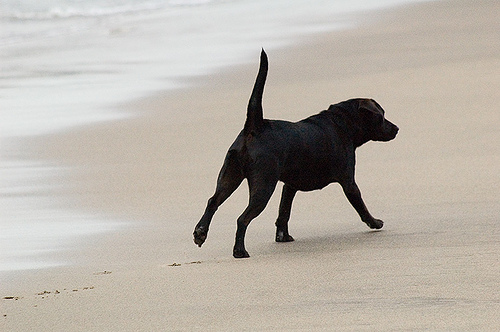

In [48]:
# Sample code to inspect image and captions from the training data
for img_path, caps in train_data.take(1):
    break
print(img_path)         # Print image path tensor
img = load_img(img_path) # Load image using helper function load_img
print(img.shape)        # Print shape of loaded image
caps = [cap.numpy().decode('utf-8') for cap in caps]  # Decode caption strings
print(caps)             # Print decoded captions
Image.open(img_path.numpy().decode('utf-8'))  # Display the image using PIL

In [49]:
# Define a callback class to generate text on epoch end
class GenerateText(tf.keras.callbacks.Callback):
    """
    Callback class to generate text based on an image after each epoch.

    Attributes:
    img (tensor): Image tensor used for text generation.
    caps (list): List of caption strings for reference.
    """

    def __init__(self, img=img):
        """
        Initializes GenerateText callback with an image.

        Parameters:
        img (tensor): Image tensor for text generation.
        """
        self.image = img[tf.newaxis, ...]  # Ensure image has batch dimension
        self.caps = caps  # Store list of caption strings

    def on_epoch_end(self, epochs=None, logs=None):
        """
        Generates text based on the image at the end of each epoch.

        Parameters:
        epochs (int): Number of epochs completed.
        logs (dict): Dictionary of logs containing metrics and loss.
        """
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image, temperature=temp)  # Generate text
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range=1)  # Calculate F-score
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')  # Print generated text and F-score


# **Compile the Captioner model**

In [50]:
# Define the optimizer for the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define callbacks for training
callbacks = [
    GenerateText(),  # Callback to generate text after each epoch
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)  # Early stopping to prevent overfitting
]

# Compile the Captioner model
captioner_model.compile(
    loss=masked_loss,  # Custom masked loss function for training
    optimizer=optimizer,  # Optimizer defined above
    metrics=[masked_accuracy]  # Masked accuracy metric for evaluation
)

# **Train the model**

In [51]:
# Train the model
hist = captioner_model.fit(
    train_ds.repeat(),  # Training dataset with repeat for multiple epochs
    steps_per_epoch=80,  # Number of steps (batches) per epoch
    validation_data=test_ds.repeat(),  # Validation dataset with repeat for multiple epochs
    validation_steps=20,  # Number of steps (batches) to validate on during validation
    epochs=5,  # Number of epochs for training
    callbacks=callbacks  # Callbacks to be executed during training
)

Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 5.1434 - masked_accuracy: 0.1723

Generated_text: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a, 	 f_score: 0
Generated_text: a dog, 	 f_score: 0.019914827347145576
Generated_text: girl in a clouds her blue puddle man glass together, 	 f_score: 0
80/80 [==============================] - 110s 1s/step - loss: 5.1434 - masked_accuracy: 0.1723 - val_loss: 4.8437 - val_masked_accuracy: 0.2083
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 4.8246 - masked_accuracy: 0.2207

Generated_text: a dog is a dog, 	 f_score: 0.16886511879816196
Generated_text: a man in the, 	 f_score: 0.08588482777109359
Generated_text: man playing dog and a weird children white dog a runs, 	 f_score: 0.2105263157894737
80/80 [==============================] - 104s 1s/step - loss: 4.8246 - masked_accuracy: 0.2207 - val_loss: 4.5528 - val_masked_accuracy: 0.2468
Epoch 3/5
80/80 [=

**Visualize the loss and accuracy graph**

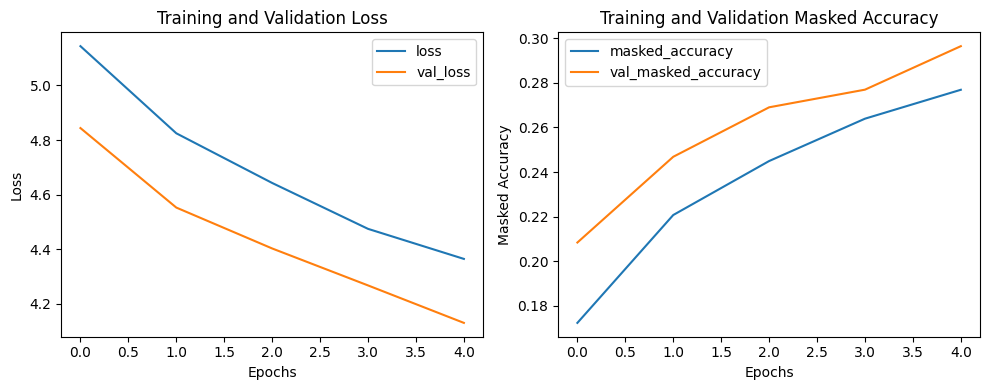

In [52]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# Subplot for training and validation loss
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='loss')            # Plot training loss
plt.plot(hist.history['val_loss'], label='val_loss')    # Plot validation loss
plt.title('Training and Validation Loss')               # Set subplot title
plt.xlabel('Epochs')                                    # Set x-axis label
plt.ylabel('Loss')                                      # Set y-axis label
plt.legend()                                            # Show legend

# Subplot for training and validation masked accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label='masked_accuracy')              # Plot training masked accuracy
plt.plot(hist.history['val_masked_accuracy'], label='val_masked_accuracy')      # Plot validation masked accuracy
plt.title('Training and Validation Masked Accuracy')                            # Set subplot title
plt.xlabel('Epochs')                                                            # Set x-axis label
plt.ylabel('Masked Accuracy')                                                   # Set y-axis label
plt.legend()                                                                    # Show legend

plt.tight_layout()  # Ensure subplots fit into the figure area without overlapping
plt.show()          # Display the plots


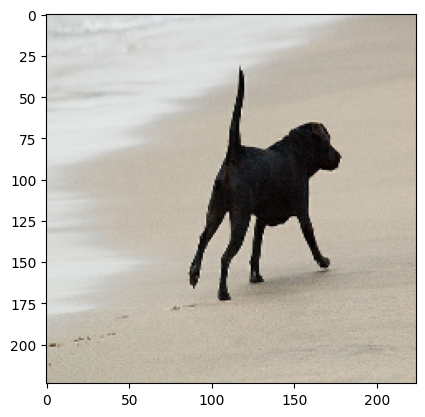

Generated Caption: a dog is a white dog is running in the the beach


In [55]:
# Take the first batch of data from train_data, containing 4 images and their captions
for img_path, caps in train_data.batch(4).take(1):
    break

# Load the first image from its path and display it using matplotlib
img = load_img(img_path[0].numpy().decode('utf-8'))  # Load image from its path
plt.imshow(img / 255.0)  # Display the image, scaling pixel values to [0, 1]
plt.show()  # Show the image in the plot

# Generate a caption for the displayed image using the captioner_model
generated_caption = captioner_model.generate_text(img[tf.newaxis, ...])  # Generate caption for the image
print(f'Generated Caption: {generated_caption}')  # Print the generated caption


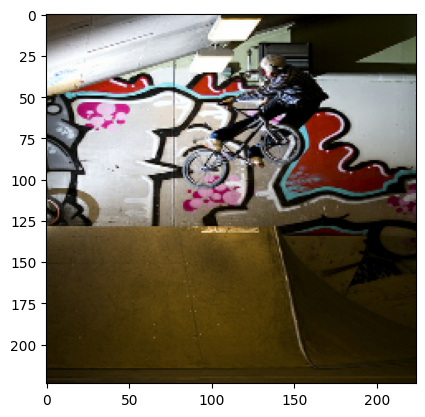

Generated Caption: a man in a white man is jumping


In [56]:
img = load_img(img_path[3].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

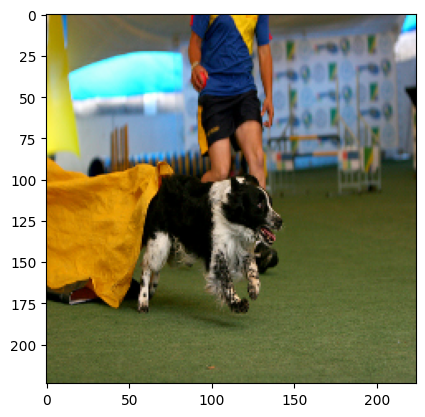

Generated Caption: a dog is dog is to the air


In [57]:
img = load_img(img_path[2].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

In [58]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Function to compute BLEU scores
def compute_bleu_scores(actual, candidate):
    ref_tokenized = [nltk.word_tokenize(cap.lower().decode('utf-8')) for cap in actual]
    candidate_tokenized = nltk.word_tokenize(candidate.lower().decode('utf-8'))
    bleu_1 = sentence_bleu(ref_tokenized, candidate_tokenized, weights=(1, 0, 0, 0))
    bleu_2 = sentence_bleu(ref_tokenized, candidate_tokenized, weights=(0.5, 0.5, 0, 0))
    return bleu_1, bleu_2


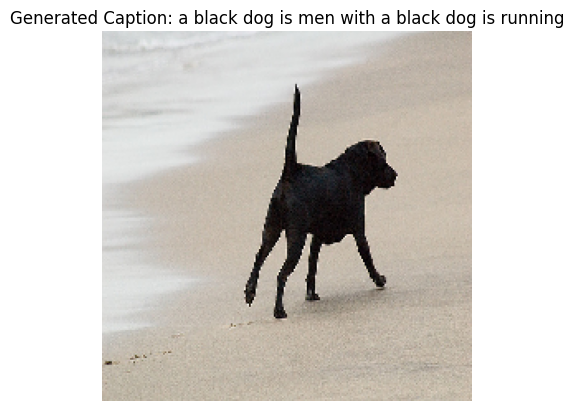

Actual Captions:
- A black dog is running along the beach .
- A black dog running on a beach .
- A black dog running on the beach
- A dog walking away at the beach .
- "A large , black dog is running in the sand on the beach ."
BLEU-1 Score: 0.5454545454545454, BLEU-2 Score: 0.4670993664969138
-----------------------------
Average BLEU-1 Score: 0.5454545454545454, Average BLEU-2 Score: 0.4670993664969138


In [66]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Function to compute BLEU scores
def compute_bleu_scores(actual, candidate):
    ref_tokenized = [nltk.word_tokenize(cap.lower()) for cap in actual]
    candidate_tokenized = nltk.word_tokenize(candidate.lower())
    bleu_1 = sentence_bleu(ref_tokenized, candidate_tokenized, weights=(1, 0, 0, 0))
    bleu_2 = sentence_bleu(ref_tokenized, candidate_tokenized, weights=(0.5, 0.5, 0, 0))
    return bleu_1, bleu_2

# Function to generate and evaluate captions
def evaluate_captions(model, dataset):
    bleu1_scores = []
    bleu2_scores = []

    for img_path, actual_captions in dataset:
        img_path = img_path.numpy().decode('utf-8')  # Convert bytes to string
        actual_captions = [caption.decode('utf-8') for caption in actual_captions.numpy()]  # Convert bytes to string

        # Load image
        img = load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
        img_tensor = img_array[tf.newaxis, ...]

        # Generate caption
        generated_caption = model.generate_text(img_tensor)

        # Calculate BLEU scores
        bleu1, bleu2 = compute_bleu_scores(actual_captions, generated_caption)
        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)

        # Display image and generated caption
        plt.imshow(img_array/255.0)
        plt.title(f"Generated Caption: {generated_caption}")
        plt.axis('off')
        plt.show()

        # Print actual captions for reference
        print("Actual Captions:")
        for caption in actual_captions:
            print(f"- {caption}")

        # Print BLEU scores
        print(f"BLEU-1 Score: {bleu1}, BLEU-2 Score: {bleu2}")
        print("-----------------------------")

    # Calculate average BLEU scores
    avg_bleu1 = np.mean(bleu1_scores)
    avg_bleu2 = np.mean(bleu2_scores)
    print(f"Average BLEU-1 Score: {avg_bleu1}, Average BLEU-2 Score: {avg_bleu2}")

# Assuming `captioner_model` and `train_data` are defined elsewhere
# Call the function to evaluate captions
evaluate_captions(captioner_model, train_data.take(1))  # Evaluate on the first 5 examples for demonstration


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Load and preprocess the image
new_image_path = '/content/download.jpg'
img = load_img(new_image_path, target_size=(224, 224))  # Resize as per model's input size
img_array = img_to_array(img)
img_array = preprocess_input(img_array)  # Apply normalization suitable for MobilenetV3

# Add batch dimension
img_tensor = img_array[tf.newaxis, ...]  # Equivalent to tf.expand_dims(img_array, axis=0)

# Generate caption using the model
generated_caption = captioner_model.generate_text(img_tensor)

# Convert the image array back to an image for display
img = load_img(new_image_path, target_size=(224, 224))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title('Generated Caption: ' + generated_caption)
plt.show()
